In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import os 
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
gdrive_dir = "gdrive/My Drive/CS3244"
train_data_dir = os.path.join(gdrive_dir, "datasets/Train")
test_data_dir = os.path.join(gdrive_dir, "datasets/Test")
# train
subject_id_train_filepath = os.path.join(train_data_dir, "subject_id_train.txt")
X_train_filepath = os.path.join(train_data_dir, "X_train.txt")
y_train_filepath = os.path.join(train_data_dir, "y_train.txt")
# test
subject_id_test_filepath = os.path.join(test_data_dir, "subject_id_test.txt")
X_test_filepath = os.path.join(test_data_dir, "X_test.txt")
y_test_filepath = os.path.join(test_data_dir, "y_test.txt")
# features
features_filepath = os.path.join(gdrive_dir, "datasets/features.txt")

In [6]:
with open(features_filepath, 'r') as tf:
    features = tf.read().split('\n')
features = features[:-1] # remove last newline

# Read train data into pd
subject_id_train = pd.read_csv(subject_id_train_filepath, header=None)
subject_id_test = pd.read_csv(subject_id_test_filepath, header=None)
X_train_df = pd.read_csv(X_train_filepath, header=None, delim_whitespace=True)
y_train_df = pd.read_csv(y_train_filepath, header=None)

X_train_df.columns = features
#X_train_df.insert(0, 'subject_id', subject_id_train)
y_train_df.shape

(7767, 1)

In [7]:
# Read test data into pd
subject_id_test = pd.read_csv(subject_id_test_filepath, header=None)
X_test_df = pd.read_csv(X_test_filepath, header=None, delim_whitespace=True)
y_test_df = pd.read_csv(y_test_filepath, header=None)

X_test_df.columns = features

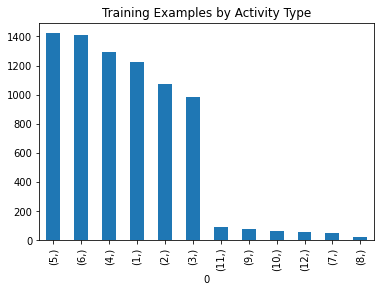

In [8]:
# histogram visualization of training data
# we know there are 12 labels
y_train_df.value_counts().plot(kind='bar',
                          title='Training Examples by Activity Type')

From the above histogram, we observe that our data is highly imbalanced for labels concerning the transition of one position to the next compared to the labels for the positions. Even amongst the position labels, a small degree of imbalance can be observed; largest between position 3 and position 5.

Resampling may need to be considered.

In [38]:
# Spliting of data set 
# We should split the data set by users rather than by a percentage
# Only worrying about having at least a few example records per activity is not sufficient (credit https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0 )

# X_train_df['subject_id'].value_counts().plot(kind='bar',
#                                   title='Training Examples by User')
# plt.show()
# observed from the histogram, we have a decent spread of data among the participants in the training set

# X_train = X_train_df[X_train_df['subject_id'] <= 27].drop(columns=['subject_id'])
# X_val = X_train_df[X_train_df['subject_id'] > 27].drop(columns=['subject_id'])

# X_train.head()

KeyError: ignored

In [13]:
y_train_df.insert(0, 'subject_id', subject_id_train)
y_train = y_train_df[y_train_df['subject_id'] <= 27]
y_val = y_train_df[y_train_df['subject_id'] > 27]
y_train = y_train.drop(columns=['subject_id'])
y_val = y_val.drop(columns=['subject_id'])
y_train_df = y_train_df.drop(columns=['subject_id'])

In [14]:
frames = [X_train_df, X_test_df]
result = pd.concat(frames)
result

tBodyAcc-Mean-1                  ...  tZAxisAcc-AngleWRTGravity-1    
0                            0.043580  ...                        -0.051718
1                            0.039480  ...                        -0.047436
2                            0.039978  ...                        -0.042271
3                            0.039785  ...                        -0.040826
4                            0.038758  ...                        -0.037080
...                               ...  ...                              ...
3157                         0.052279  ...                         0.190104
3158                         0.073745  ...                         0.187748
3159                         0.068334  ...                         0.186527
3160                         0.023016  ...                         0.192865
3161                        -0.010846  ...                         0.193402

[10929 rows x 561 columns]

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc = StandardScaler()

result_transformed = sc.fit_transform(result)
result_transformed

array([[ 0.04229753, -0.04987031, -0.18730766, ..., -0.68490752,
         0.40378404, -0.00350964],
       [ 0.0020512 , -0.01173583, -0.1194426 , ..., -0.69185739,
         0.4049132 ,  0.01258021],
       [ 0.00693757, -0.04174955, -0.04670704, ..., -0.6999948 ,
         0.40604285,  0.03198754],
       ...,
       [ 0.28530967,  0.44474641, -0.06352887, ..., -0.32004781,
         0.71029105,  0.89169481],
       [-0.1595766 ,  0.33073808,  0.07595511, ..., -0.32860893,
         0.67885137,  0.91550876],
       [-0.49200392, -0.03162923, -0.21705211, ..., -0.32931876,
         0.67611038,  0.9175264 ]])

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # for LDA analysis
lda = LDA()
X_lda = lda.fit_transform(result_transformed, pd.concat([y_train_df, y_test_df]))
X_lda.shape

(10929, 11)

In [18]:
X_train_lda = X_lda[0:7767]
X_test_lda = X_lda[7767:]

In [41]:
from sklearn.cluster import KMeans

def add_cluster_as_feature(X_train, X_test, k):
  kmeans = KMeans(n_clusters=k, random_state=151001)
  kmeans.fit(X_train)

  train_clusters = kmeans.labels_
  X_train_with_cluster = X_train.copy()
  # X_train_with_cluster = pd.DataFrame()
  X_train_with_cluster['cluster'] = train_clusters

  test_clusters = kmeans.predict(X_test)
  X_test_with_cluster = X_test.copy()
  # X_test_with_cluster = pd.DataFrame()
  X_test_with_cluster['cluster'] = test_clusters

  return X_train_with_cluster, X_test_with_cluster

In [20]:
def get_best_k_with(X_train, X_test, y_train, y_test, model):
  accuracies = {}

  for i in range(2, 15):
    X_train_with_cluster, X_test_with_cluster = add_cluster_as_feature(X_train, X_test, i)

    model.fit(X_train_with_cluster, y_train)

    y_pred = model.predict(X_test_with_cluster)
    accuracy = model.score(X_test_with_cluster, y_test_df)

    accuracies[i] = accuracy

  return accuracies

In [42]:
from sklearn.linear_model import LogisticRegression

X_train_lda_df = pd.DataFrame(data = X_train_lda)
X_test_lda_df = pd.DataFrame(data = X_test_lda)

get_best_k_with(X_train_lda_df, X_test_lda_df, y_train_df, y_test_df, LogisticRegression())

{2: 0.9734345351043643,
 3: 0.9740670461733081,
 4: 0.9740670461733081,
 5: 0.9737507906388362,
 6: 0.9728020240354206,
 7: 0.9734345351043643,
 8: 0.9750158127767236,
 9: 0.9724857685009488,
 10: 0.9705882352941176,
 11: 0.9721695129664769,
 12: 0.9709044908285895,
 13: 0.971853257432005,
 14: 0.971853257432005}

In [ ]:
!pip install tslearn

     |████████████████████████████████| 793 kB 5.0 MB/s 


In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

dtw = KNeighborsTimeSeriesClassifier()
dtw.fit(X_train_lda, y_train_df)

classes = dtw.predict(X_test_lda[0:100])

KNeighborsTimeSeriesClassifier()

In [ ]:
def predictWithStatus(startIdx, endIdx):
  classes = []
  for i in range(startIdx, endIdx):
    classes.append(dtw.predict(X_test_lda[i])[0])
    print('done with ' + str(i))
  return classes

In [ ]:
from numpy import concatenate

# predict batch by batch
classes = concatenate([classes, predictWithStatus(100, 3162)])
classes

NameError: ignored

In [ ]:
from sklearn import metrics

labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING','STAND_TO_SIT','SIT_TO_STAND','SIT_TO_LIE','LIE_TO_SIT','STAND_TO_LIE','LIE_TO_STAND']
print(metrics.classification_report(y_test_df, classes, target_names=labels, digits=3))

pasted it cause
		                    precision    recall  f1-score   support
                   WALKING      0.984     0.990     0.987       496
		  WALKING_UPSTAIRS      0.987     0.989     0.988       471
		WALKING_DOWNSTAIRS      0.995     0.986     0.990       420
		           SITTING      0.945     0.888     0.916       508
		          STANDING      0.902     0.960     0.930       556
		            LAYING      1.000     0.998     0.999       545
		      STAND_TO_SIT      0.786     0.957     0.863        23
		      SIT_TO_STAND      1.000     1.000     1.000        10
		        SIT_TO_LIE      0.706     0.750     0.727        32
		        LIE_TO_SIT      0.800     0.640     0.711        25
		      STAND_TO_LIE      0.854     0.714     0.778        49
		      LIE_TO_STAND      0.724     0.778     0.750        27
		
		          accuracy                          0.958      3162
		         macro avg      0.890     0.887     0.887      3162
		      weighted avg      0.958     0.958     0.957      3162

Trying DTW KNN without LDA

However, its too slow, one instance takes around 2 to 3 mins

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

dtw = KNeighborsTimeSeriesClassifier()
dtw.fit(X_train_df, y_train_df)

KNeighborsTimeSeriesClassifier()

In [ ]:
def predictWithStatusWithoutLDA(startIdx, endIdx):
  classes = []
  for i in range(startIdx, endIdx):
    classes.append(dtw.predict(X_test_df.iloc[i])[0])
    print('done with ' + str(i))
  return classes

classes_without_lda = []

In [ ]:
from numpy import concatenate

classes_without_lda = concatenate([classes_without_lda, predictWithStatusWithoutLDA(0, 15)])
classes_without_lda

In [ ]:
from sklearn import metrics

# labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING','STAND_TO_SIT','SIT_TO_STAND','SIT_TO_LIE','LIE_TO_SIT','STAND_TO_LIE','LIE_TO_STAND']
print(metrics.classification_report(y_test_df[0:30], classes_without_lda,  digits=3))

              precision    recall  f1-score   support

           5      1.000     1.000     1.000        15

    accuracy                          1.000        15
   macro avg      1.000     1.000     1.000        15
weighted avg      1.000     1.000     1.000        15

